## Feature Selection

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from scipy.stats import chi2_contingency

In [6]:
# load the data prepared and saved before - BEFORE encoding of categorical predictors
with open('data/houses_prepared.pkl', 'rb') as f:
    houses_train = pickle.load(f)
    houses_test = pickle.load(f)

houses_test.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Alley,Lot_Shape,Land_Contour,Lot_Config,...,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Fence,Misc_Feature,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price
0,1,526301100,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,No_Alley_Access,Slightly_Irregular,Lvl,Corner,...,Partial_Pavement,210,62,No_Fence,None,5,2010,WD,Normal,215000
1,2,526350040,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,No_Alley_Access,Regular,Lvl,Inside,...,Paved,140,0,Minimum_Privacy,None,6,2010,WD,Normal,105000
2,3,526351010,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,No_Alley_Access,Slightly_Irregular,Lvl,Corner,...,Paved,393,36,No_Fence,Other,6,2010,WD,Normal,172000
3,4,526353030,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,No_Alley_Access,Regular,Lvl,Corner,...,Paved,0,0,No_Fence,None,4,2010,WD,Normal,244000
4,5,527105010,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,No_Alley_Access,Slightly_Irregular,Lvl,Inside,...,Paved,212,34,Minimum_Privacy,None,3,2010,WD,Normal,189900


### Initial Filtering of Variables
We can pre-select variables for the model checking the relationship of each of them separately with the Y - outcome variable.

Then we can, for example, choose `k` variables mostly individually related to the outcome.

Do the following separately for the `quantitative` and `qualitative` variables - correlations

### Quantitative (Numeric) explanatory variables - correlations
Correlation analysis with a target variable for quantitative variables - also allows one for identification of potential collinearity (strong correlation between predictors (Xi) 
).

In [11]:
houses_numeric_columns = houses_train.select_dtypes(include=[np.number]).columns
print(houses_numeric_columns)

Index(['Order', 'PID', 'Lot_Frontage', 'Lot_Area', 'Year_Built',
       'Year_Remod_Add', 'BsmtFin_SF_1', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'First_Flr_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath',
       'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr',
       'TotRms_AbvGrd', 'Fireplaces', 'Garage_Cars', 'Garage_Area',
       'Wood_Deck_SF', 'Open_Porch_SF', 'Mo_Sold', 'Year_Sold', 'Sale_Price'],
      dtype='object')


In [13]:
# exlude 'Order', 'PID' - which do not make sense as predictors
houses_numeric_columns = houses_numeric_columns[2:]

In [15]:
print(houses_numeric_columns)

Index(['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'BsmtFin_SF_1', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'First_Flr_SF',
       'Gr_Liv_Area', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath',
       'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd',
       'Fireplaces', 'Garage_Cars', 'Garage_Area', 'Wood_Deck_SF',
       'Open_Porch_SF', 'Mo_Sold', 'Year_Sold', 'Sale_Price'],
      dtype='object')


#### Mutually correlated (irrelevant) variables
We can calculate correlations between numeric variables to identify redundant features (not always necessary - some methods are robust to the problem of `multicollinearity`)

In [20]:
# compute correlation matrix, handling missing data (NaN)
houses_correlations = houses_train[houses_numeric_columns].corr(method = 'pearson')
houses_correlations

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,BsmtFin_SF_1,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,Gr_Liv_Area,Bsmt_Full_Bath,...,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Mo_Sold,Year_Sold,Sale_Price
Lot_Frontage,1.000000,0.115291,0.030037,0.074207,0.052686,0.135015,0.205054,0.248287,0.212411,0.016822,...,0.017989,0.211761,0.077580,0.146692,0.190845,0.024637,0.091177,0.042201,-0.020129,0.202630
Lot_Area,0.115291,1.000000,0.015173,0.023155,-0.034395,0.045323,0.272318,0.356419,0.311872,0.112675,...,-0.008471,0.227322,0.285269,0.192339,0.234190,0.194602,0.131548,0.004470,-0.002465,0.258027
Year_Built,0.030037,0.015173,1.000000,0.616172,-0.156741,0.133447,0.401406,0.298350,0.236142,0.210586,...,-0.138857,0.110715,0.152689,0.531145,0.462747,0.214331,0.176572,0.050877,-0.022539,0.538535
Year_Remod_Add,0.074207,0.023155,0.616172,1.000000,-0.012357,0.180048,0.291131,0.232910,0.325241,0.126165,...,-0.137345,0.215216,0.125752,0.414208,0.355722,0.205557,0.228340,0.053885,0.061038,0.523806
BsmtFin_SF_1,0.052686,-0.034395,-0.156741,-0.012357,1.000000,0.497121,-0.150204,-0.119776,0.055635,-0.466343,...,0.092250,0.115175,-0.117304,-0.052511,-0.087959,-0.144701,-0.010858,0.017192,-0.044098,-0.116810
Bsmt_Unf_SF,0.135015,0.045323,0.133447,0.180048,0.497121,1.000000,0.404523,0.279897,0.237038,-0.411132,...,0.086121,0.263051,0.009285,0.179854,0.156281,-0.051004,0.110534,0.043650,-0.033753,0.183782
Total_Bsmt_SF,0.205054,0.272318,0.401406,0.291131,-0.150204,0.404523,1.000000,0.796422,0.468066,0.315165,...,0.003955,0.298391,0.325013,0.432396,0.485653,0.243527,0.236605,0.038404,-0.010239,0.605192
First_Flr_SF,0.248287,0.356419,0.298350,0.232910,-0.119776,0.279897,0.796422,1.000000,0.578570,0.254204,...,0.096734,0.392520,0.404530,0.435629,0.493127,0.241633,0.247274,0.064699,-0.009127,0.602053
Gr_Liv_Area,0.212411,0.311872,0.236142,0.325241,0.055635,0.237038,0.468066,0.578570,1.000000,0.054480,...,0.083533,0.809629,0.464491,0.491618,0.504947,0.258926,0.361889,0.051944,-0.013091,0.715920
Bsmt_Full_Bath,0.016822,0.112675,0.210586,0.126165,-0.466343,-0.411132,0.315165,0.254204,0.054480,1.000000,...,-0.022402,-0.043435,0.147354,0.167818,0.195885,0.213586,0.072680,0.009790,0.015277,0.266054


<Axes: >

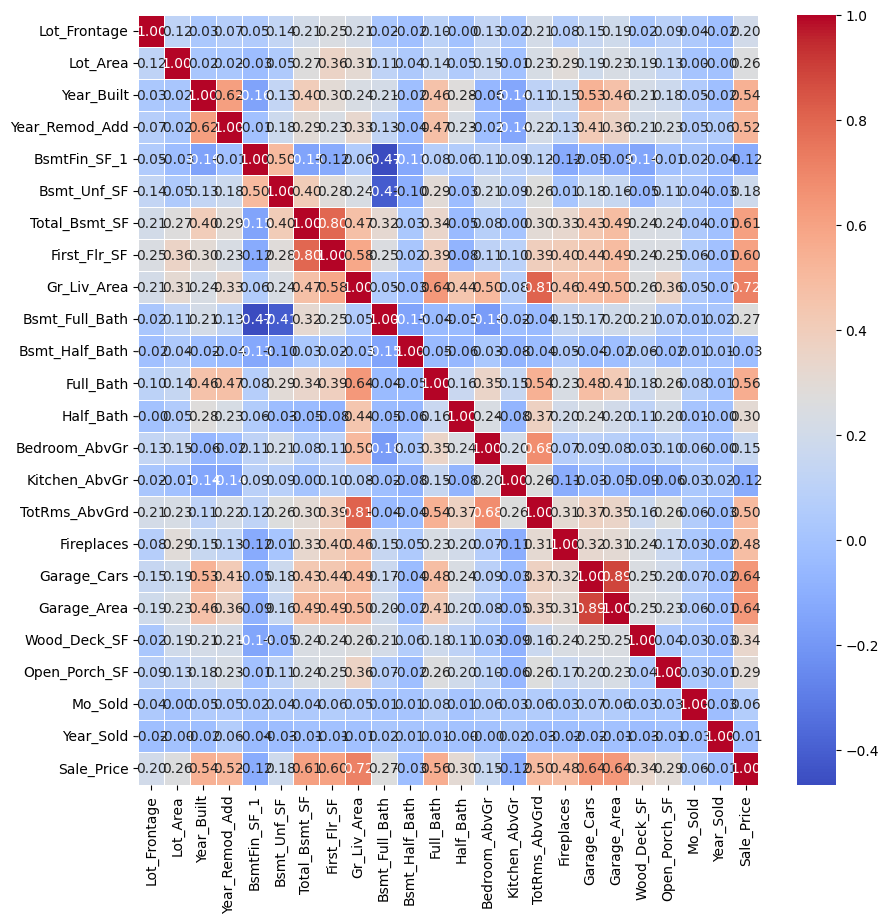

In [32]:
plt.figure(figsize=(10, 10))
sns.heatmap(
            houses_correlations, # data source
            annot = True, # numbers in cells
            cmap = 'coolwarm',
            fmt = '.2f',
            linewidths = 0.5
           )

<Axes: >

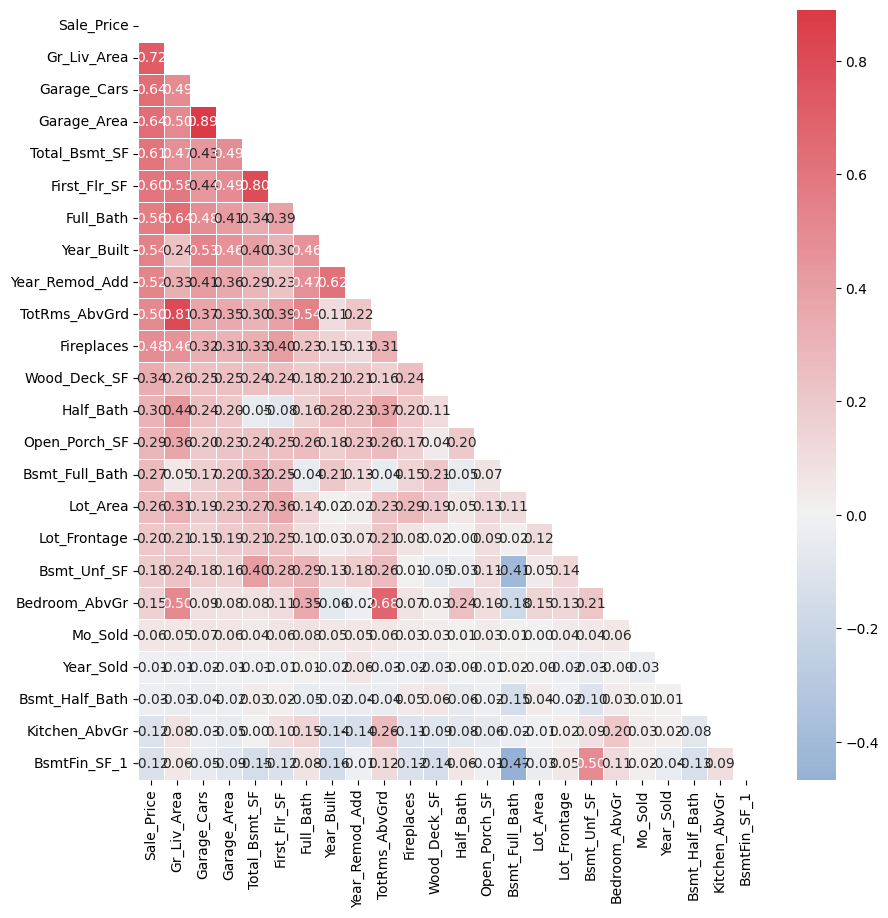

In [34]:
mask = np.triu(np.ones_like(houses_correlations, dtype = bool))
# get the correlation of all Xi with Y and sort by the values
correlation_with_sale_price = houses_correlations['Sale_Price'].sort_values(ascending = False)
ordered_columns = correlation_with_sale_price.index

# reorder the correlation matrix based on this order
houses_correlations = houses_correlations[ordered_columns].loc[ordered_columns]

my_cmap = sns.diverging_palette(250, 10, as_cmap = True)

plt.figure(figsize=(10, 10))
sns.heatmap(
    houses_correlations,
    annot = True,
    cmap = my_cmap,
    mask = mask,
    fmt = '.2f',
    linewidths = 0.5,
    # this argument ensures that the color map is centered at 0,
    # meaning 0 will be displayed in white
    center = 0
)

<Axes: >

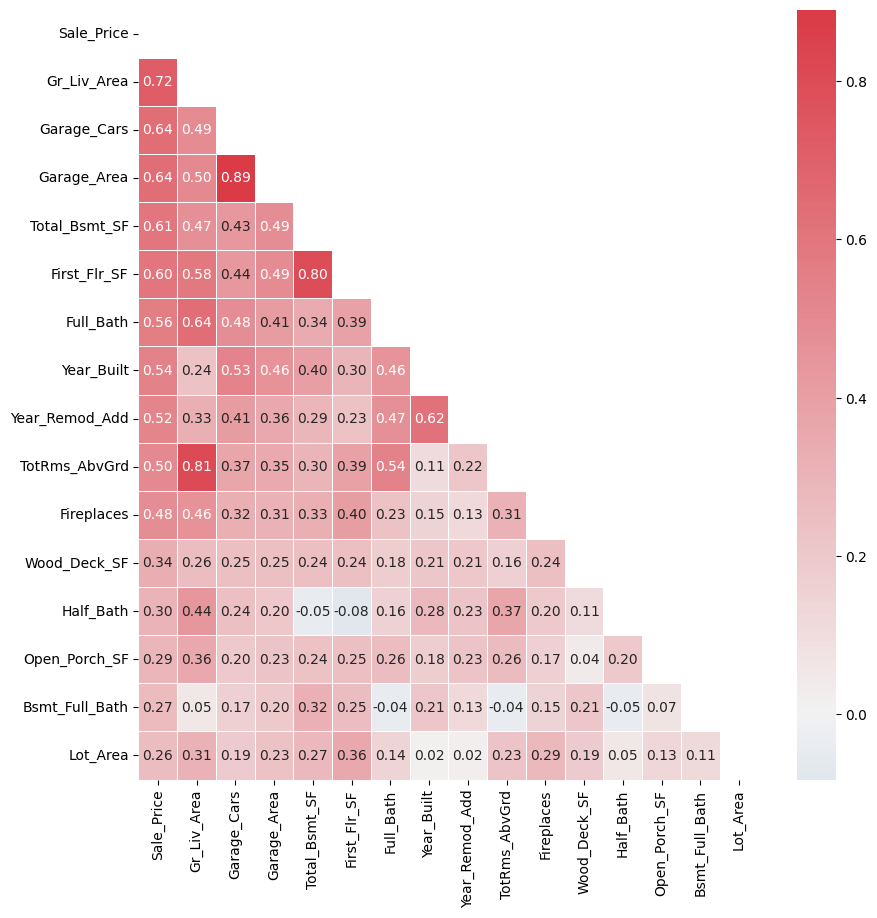

In [38]:
# focus on the first 15 variables most correlated with Y - outcome variable

plt.figure(figsize = (10, 10))
sns.heatmap(
    houses_correlations.iloc[:16, :16], # 16 as we have empty row for Sale_Price on top
    annot = True, 
    cmap = my_cmap,
    mask = mask[:16, :16], # remember to limit also the mask!
    fmt = '.2f',
    linewidths = 0.5,
    center = 0
)

Strong correlations, although not extremely high \
You can also see the potential problem of `collinearity` (interrelationship between predictors):

- Garage_Cars and Garage_Area
- Gr_liv_Area and TotRms_AbvGrd
- FirstFlr_SF and Total_Bsmt_SF

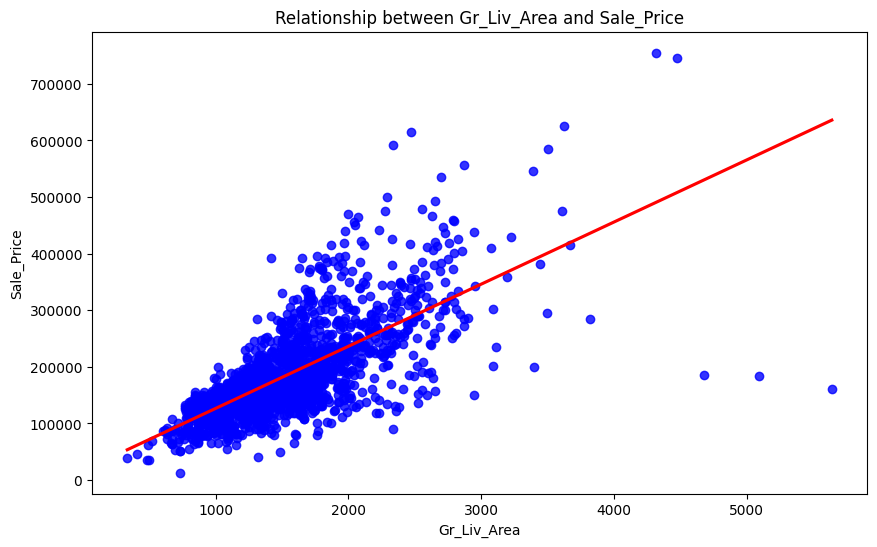

In [48]:
# see the relationship of the Y variable with the most strongly correlated Xi variables
# Gr_Liv_Area

plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'Gr_Liv_Area',
    y = 'Sale_Price',
    data = houses_train,
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color': 'red'},
    ci = None # No confidence interval for the line
)

plt.title('Relationship between Gr_Liv_Area and Sale_Price')
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Sale_Price')
plt.show()

# 5 very large houses (area > 4,000), 
# including 3 outliers (area > 4,500)
# - not matching the relationship (low_priced)

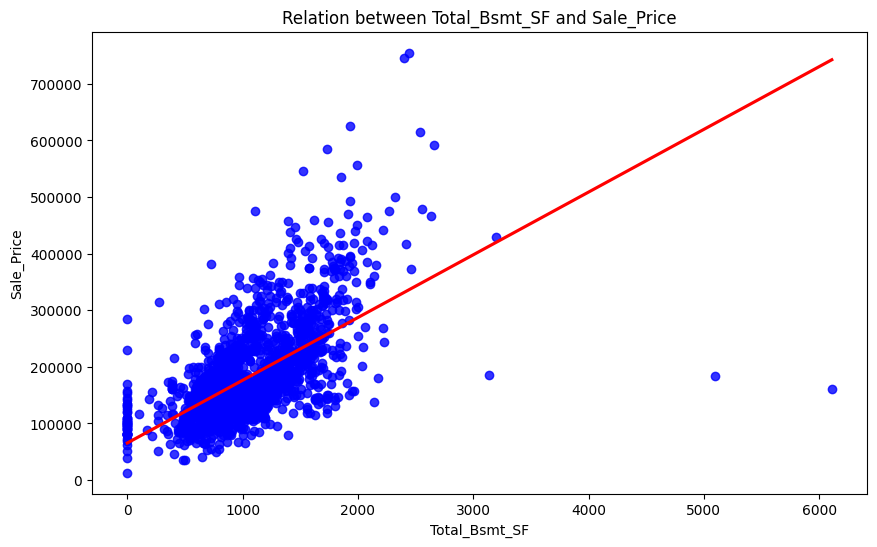

In [54]:
# Total_Bsmt_SF

plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'Total_Bsmt_SF',
    y = 'Sale_Price', 
    data = houses_train,
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color' : 'red'},
    ci = None
)

plt.title('Relation between Total_Bsmt_SF and Sale_Price')
plt.xlabel('Total_Bsmt_SF')
plt.ylabel('Sale_Price')
plt.show()

# here again one can see (same?) 3 outliers in the bottom right quadrant
# - they might have impact on the results of traditional econometric models

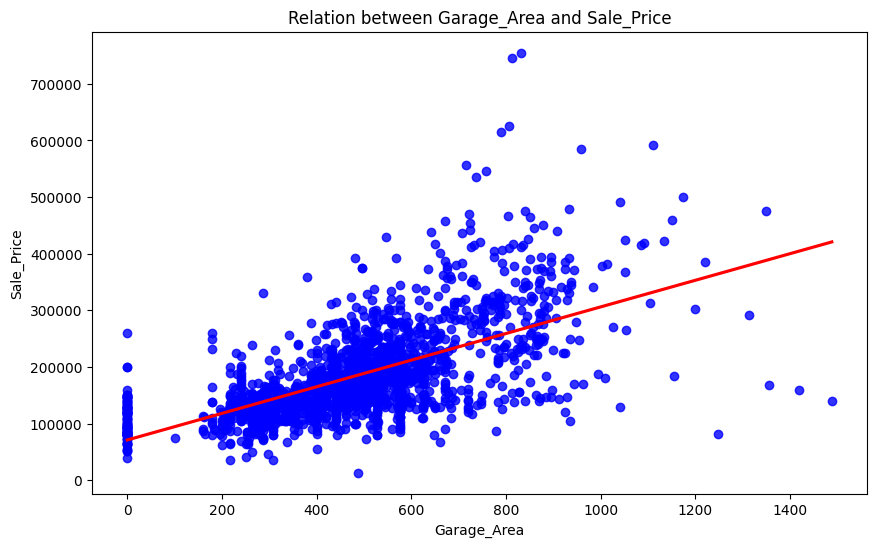

In [68]:
# Garage_Area

# strongly correlated with Garage_Cars

plt.figure(figsize=(10, 6))
sns.regplot(
    x = 'Garage_Area',
    y = 'Sale_Price',
    data = houses_train,
    scatter_kws = {'color' : 'blue'},
    line_kws = {'color' : 'red'},
    ci = None
)

plt.title('Relation between Garage_Area and Sale_Price')
plt.xlabel('Garage_Area')
plt.ylabel('Sale_Price')
plt.show()

In [70]:
# create a list of SELECTED numerical predictors Xi:
# 15 with the highest Pearson correlation with the Sale_Price

houses_selected_numeric_vars = correlation_with_sale_price.index[1:16].tolist()
# remember to omit the first 'Sale_Price' from the list - [1:16] in our case

print(houses_selected_numeric_vars)

['Gr_Liv_Area', 'Garage_Cars', 'Garage_Area', 'Total_Bsmt_SF', 'First_Flr_SF', 'Full_Bath', 'Year_Built', 'Year_Remod_Add', 'TotRms_AbvGrd', 'Fireplaces', 'Wood_Deck_SF', 'Half_Bath', 'Open_Porch_SF', 'Bsmt_Full_Bath', 'Lot_Area']


In [72]:
# but also exclude 3 mutually correlated: Garage_Cars, TotRms_AbvGrd, First_Flr_SF

houses_selected_numeric_vars.remove('Garage_Cars')
houses_selected_numeric_vars.remove('TotRms_AbvGrd')
houses_selected_numeric_vars.remove('First_Flr_SF')

houses_selected_numeric_vars

['Gr_Liv_Area',
 'Garage_Area',
 'Total_Bsmt_SF',
 'Full_Bath',
 'Year_Built',
 'Year_Remod_Add',
 'Fireplaces',
 'Wood_Deck_SF',
 'Half_Bath',
 'Open_Porch_SF',
 'Bsmt_Full_Bath',
 'Lot_Area']

### Qualitative (Categorical) variables

In [76]:
houses_categorical_variables = houses_train.select_dtypes('object').columns

print(houses_categorical_variables)

Index(['MS_SubClass', 'MS_Zoning', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Lot_Config', 'Land_Slope', 'Neighborhood', 'Condition_1', 'Bldg_Type',
       'House_Style', 'Overall_Qual', 'Overall_Cond', 'Roof_Style',
       'Exterior_1st', 'Exterior_2nd', 'Mas_Vnr_Type', 'Exter_Qual',
       'Exter_Cond', 'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Heating_QC', 'Central_Air',
       'Electrical', 'Kitchen_Qual', 'Fireplace_Qu', 'Garage_Type',
       'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Paved_Drive', 'Fence',
       'Misc_Feature', 'Sale_Type', 'Sale_Condition'],
      dtype='object')


In [78]:
# check their relationship with the Y - target variable

# because the target variable is quantitative (Numeric) and explanatory variables are -
# qualitative (Categorical), one can use the analysis of variance (ANOVA)

# see the example for a variable 'MS_SubClass'

# Fit hte ANOVA model (OLS regression)
# The C() function is used to indicate that MS_SubClass is a categorical variable - then
# it is automatically recoded into dummies

model = smf.ols(
    'Sale_Price ~ C(MS_SubClass)',
    data = houses_train
).fit()

# perform ANOVA on the fitted model
anova_table = anova_lm(model)

anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(MS_SubClass),11.0,3.163673e+12,2.876067e+11,59.152635,1.896894e-113
Residual,1929.0,9.379012e+12,4.862111e+09,NaN,NaN


In [92]:
# The F statistic is used to verify the Null Hypothesis that:
# H0: MS_SubClass does NOT impact the Sale_Price
# i.e. average Sale_Price does not differ for different values of MS_SubClass

# The higher the F-statistic (or the lower its p-value) the stronger we reject H0

print('F-statistic: ',anova_table['F'].iloc[0])
print('p-value: ',anova_table['PR(>F)'].iloc[0])

# based on results: we reject H0
# Xi does impact the Y

F-statistic:  59.152635292479395
p-value:  1.8968940644338892e-113


In [102]:
def anova_for_categorical_vars(dataset, dep_var, cat_vars):
    results = [] # initialize a list to store the results
    for var in cat_vars:
        model = smf.ols(
            f'{dep_var} ~ C({var})',
            data = dataset
        ).fit()
        
        anova_table = anova_lm(model)
        
        # extract the F-statistic and p-value from the ANOVA table
        f_statistic = anova_table['F'].iloc[0]
        p_value = anova_table['PR(>F)'].iloc[0]

        # append the results to the list
        results.append([var, f_statistic, p_value])

    # create a DataFrame with the results
    anova_results_df = pd.DataFrame(
        results,
        columns = ['Variable', 'F-statistic', 'p-value']
    )

    # sort the DataFrame by F-statistic in decreasing order
    # ascending = false, because we need to have most strongly correlated vars in first row
    anova_results_df = anova_results_df.sort_values(by = 'F-statistic', ascending = False)

    return anova_results_df

In [104]:
# apply the function to our data

houses_anova_results = anova_for_categorical_vars(
    houses_train,
    'Sale_Price',
    houses_categorical_variables
)

print(houses_anova_results)

          Variable  F-statistic        p-value
17      Exter_Qual   592.843153  2.546349e-273
28    Kitchen_Qual   550.172896  1.393897e-258
11    Overall_Qual   489.375685   0.000000e+00
20       Bsmt_Qual   388.357271  8.380136e-289
31   Garage_Finish   266.960041  5.351229e-145
29    Fireplace_Qu   178.505349  1.713150e-156
19      Foundation   171.918342  4.224578e-126
26     Central_Air   138.787363   5.433354e-31
16    Mas_Vnr_Type   129.928706   1.097031e-76
25      Heating_QC   127.296097   1.397421e-96
30     Garage_Type   124.024501  4.249802e-114
22   Bsmt_Exposure   116.011869   8.833151e-89
7     Neighborhood   115.988270   0.000000e+00
23  BsmtFin_Type_1    89.101251   7.044660e-99
37       Sale_Type    88.911583   1.910462e-69
13      Roof_Style    88.633219   1.469077e-37
38  Sale_Condition    84.879800   1.710445e-66
34     Paved_Drive    79.473191   6.724915e-34
3        Lot_Shape    70.317833   3.653776e-43
0      MS_SubClass    59.152635  1.896894e-113
1        MS_Z

<Axes: xlabel='Exter_Qual', ylabel='Sale_Price'>

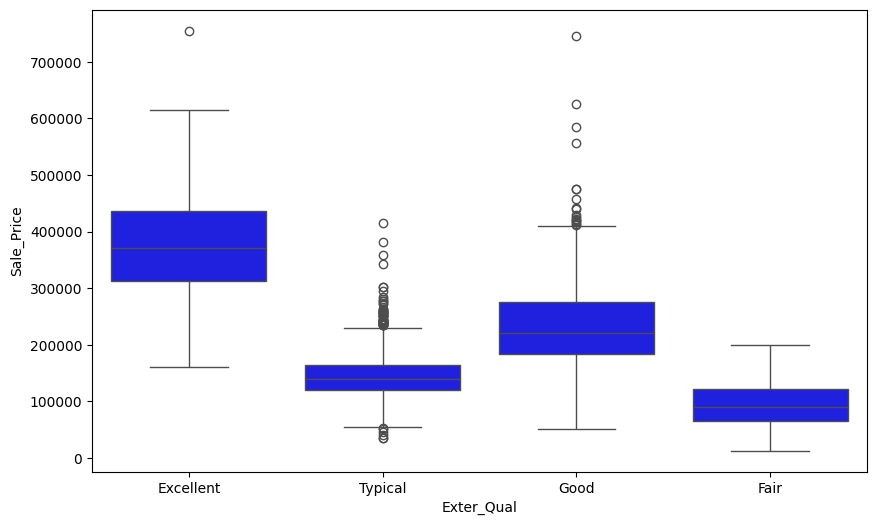

In [116]:
# see the relation of the Y - target variable with the tree categorical variables - Xi 
# which are most strongly associated with it
# Exter_Qual

plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'Exter_Qual',
    y = 'Sale_Price',
    data = houses_train,
    color = 'blue'
)

In [126]:
houses_train['Exter_Qual'].value_counts()

Exter_Qual
Typical      1201
Good          658
Excellent      65
Fair           17
Name: count, dtype: int64

<Axes: xlabel='Exter_Qual', ylabel='Sale_Price'>

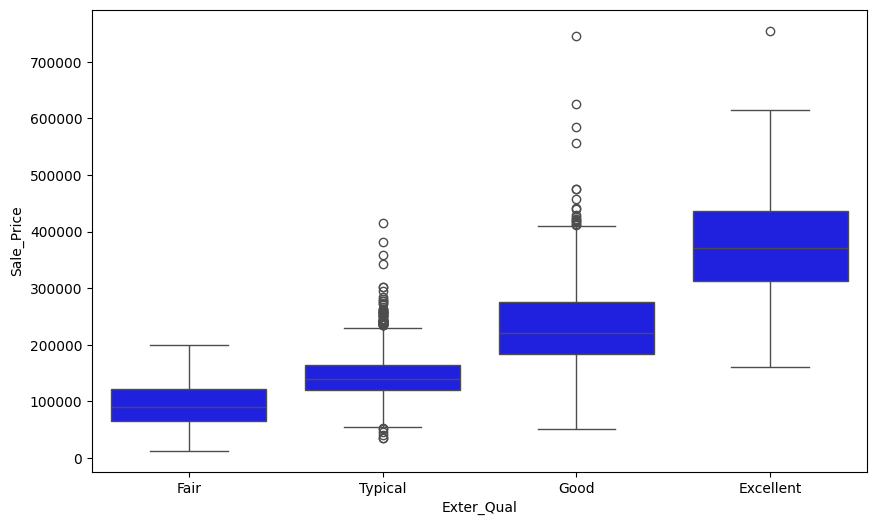

In [118]:
# we need to adjust the order of labels on the horizontal axis

plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'Exter_Qual',
    y = 'Sale_Price',
    data = houses_train,
    color = 'blue',
    order = ['Fair', 'Typical', 'Good', 'Excellent']
)

In [124]:
houses_train['Kitchen_Qual'].value_counts()

Kitchen_Qual
Typical      994
Good         771
Excellent    132
Fair          44
Name: count, dtype: int64

<Axes: xlabel='Kitchen_Qual', ylabel='Sale_Price'>

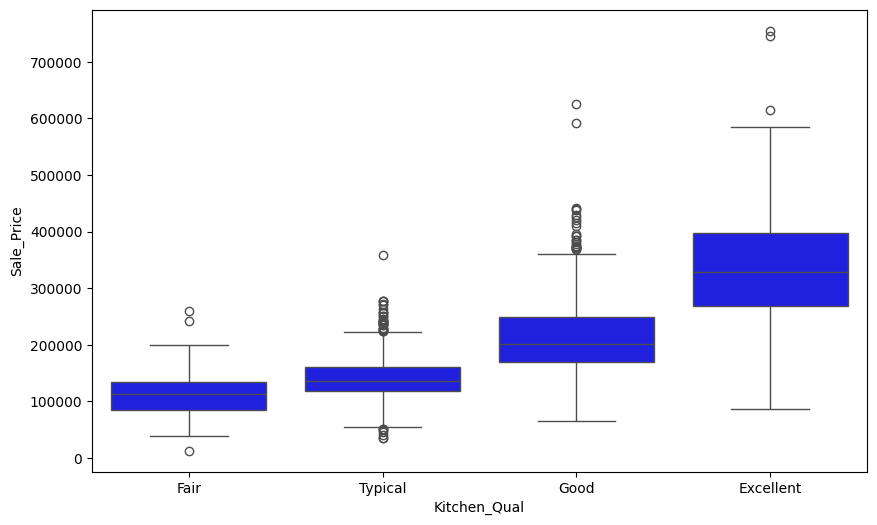

In [120]:
# Check the relation of Kitchen_Qual and Sale_Price

plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'Kitchen_Qual',
    y = 'Sale_Price',
    data = houses_train,
    color = 'blue',
    order = ['Fair', 'Typical', 'Good', 'Excellent']
)

In [122]:
houses_train['Overall_Qual'].value_counts()

Overall_Qual
Average           554
Above_Average     486
Good              397
Very_Good         238
Below_Average     141
Excellent          68
Fair               26
Very_Excellent     23
Poor                5
Very_Poor           3
Name: count, dtype: int64

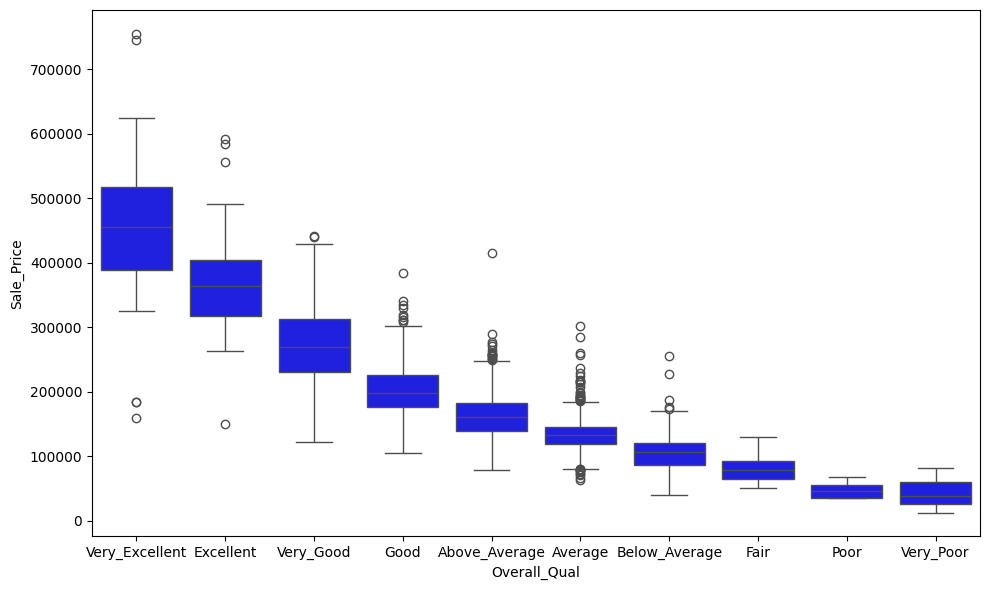

In [132]:
# check the relation of Overall_Qual and Sale_Price

plt.figure(figsize=(10, 6))
sns.boxplot(
    x = 'Overall_Qual',
    y = 'Sale_Price',
    data = houses_train,
    color = 'blue',
    order = [
        'Very_Excellent', 'Excellent', 'Very_Good', 'Good', 'Above_Average',
        'Average', 'Below_Average', 'Fair', 'Poor', 'Very_Poor'
    ]
)
plt.tight_layout()

In [142]:
# check mutual relationships between categorical predictors Xi with Xi+1 in a way similar 
# to correlation matrix

# the strength of relation between two Categorical variables can be tested using the 
# Cramer's V coefficient. Higher values mean stronger relationship. 
# It takes values from 0 to 1.
# If both variables have only two levels, Cramer's V take values from -1 to 1

def cramers_v(contingency_table):
    ''' Calculate Cramer's V statistic from a contingency table. '''
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n*(min(contingency_table.shape) - 1)))




def calculate_cramers_v_matrix(dataset, cat_vars):
    ''' Calculate the Cramer's V for each pair of categorical variables. '''
    # create an empty matrix to store the results
    cramers_v_matrix = pd.DataFrame(np.zeros((len(cat_vars), len(cat_vars))),
                                   columns = cat_vars,
                                   index = cat_vars)
    for i in range(len(cat_vars)):
        for j in range(i, len(cat_vars)): # to avoid recalculating for the same pair
            var_1 = cat_vars[i]
            var_2 = cat_vars[j]

            # create a contingency table for the two variables
            contingency_table = pd.crosstab(dataset[var_1], dataset[var_2])

            # calculate Cramer's V
            cramers_v_value = cramers_v(contingency_table)

            cramers_v_matrix.loc[var_1, var_2] = cramers_v_value
            cramers_v_matrix.loc[var_2, var_1] = cramers_v_value  # symmetric matrix

    return cramers_v_matrix

In [144]:
# apply the analysis to our data
houses_cramers_v_matrix = calculate_cramers_v_matrix(
    houses_train,
    houses_categorical_variables
)

In [146]:
# order variables in rows and columns according to the (decreasing) strength of their
# relationship with the outcome variable Y - 'Sale_Price' -> remember ANOVA results

houses_anova_results.head()

,Variable,F-statistic,p-value
17,Exter_Qual,592.843153,2.546349e-273
28,Kitchen_Qual,550.172896,1.393897e-258
11,Overall_Qual,489.375685,0.000000e+00
20,Bsmt_Qual,388.357271,8.380136e-289
31,Garage_Finish,266.960041,5.351229e-145


In [150]:
# reorder the Cramer's V matrix based on this order
variables_order = houses_anova_results['Variable'].tolist()

houses_cramers_v_matrix = houses_cramers_v_matrix[variables_order].loc[variables_order]

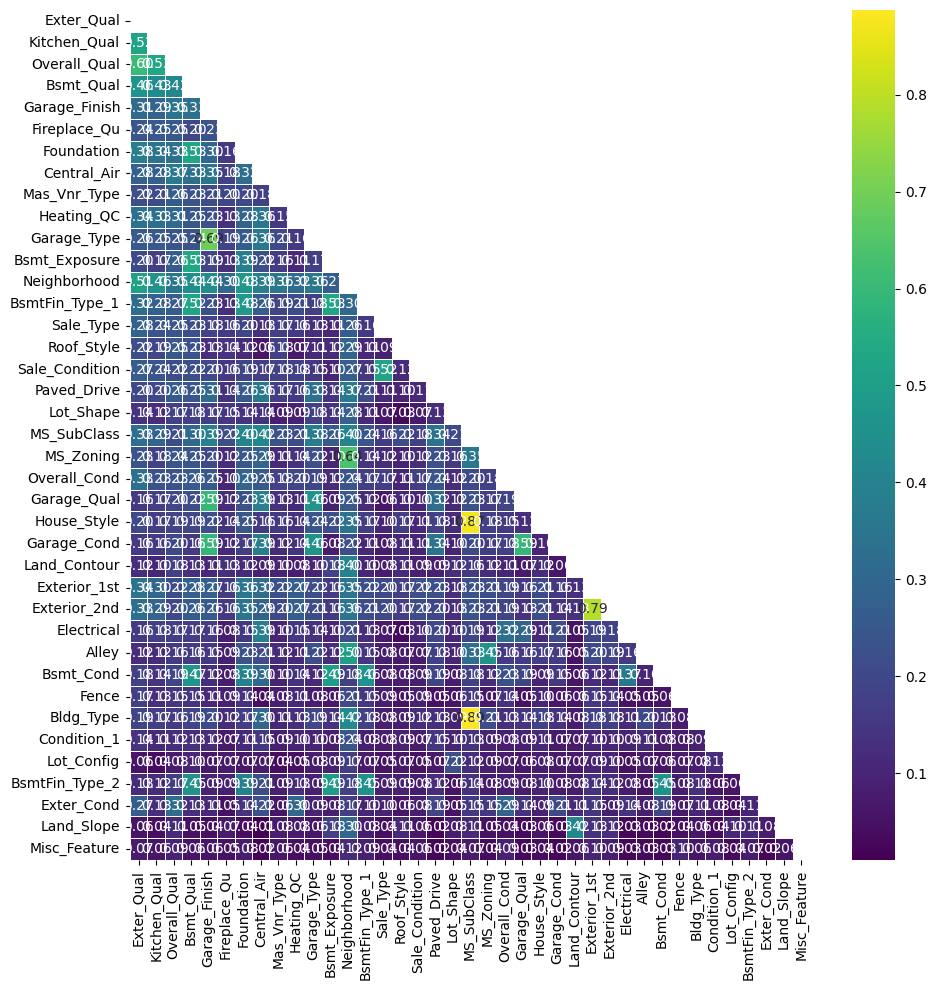

In [158]:
# heatmap ignoring the upper triangle

mask = np.triu(np.ones_like(houses_cramers_v_matrix, dtype = bool))

plt.figure(figsize=(10, 10))
sns.heatmap(
    houses_cramers_v_matrix,
    annot = True,
    cmap = 'viridis',
    fmt = '.2f',
    mask = mask,
    linewidths = 0.5
)
plt.tight_layout()

<Axes: >

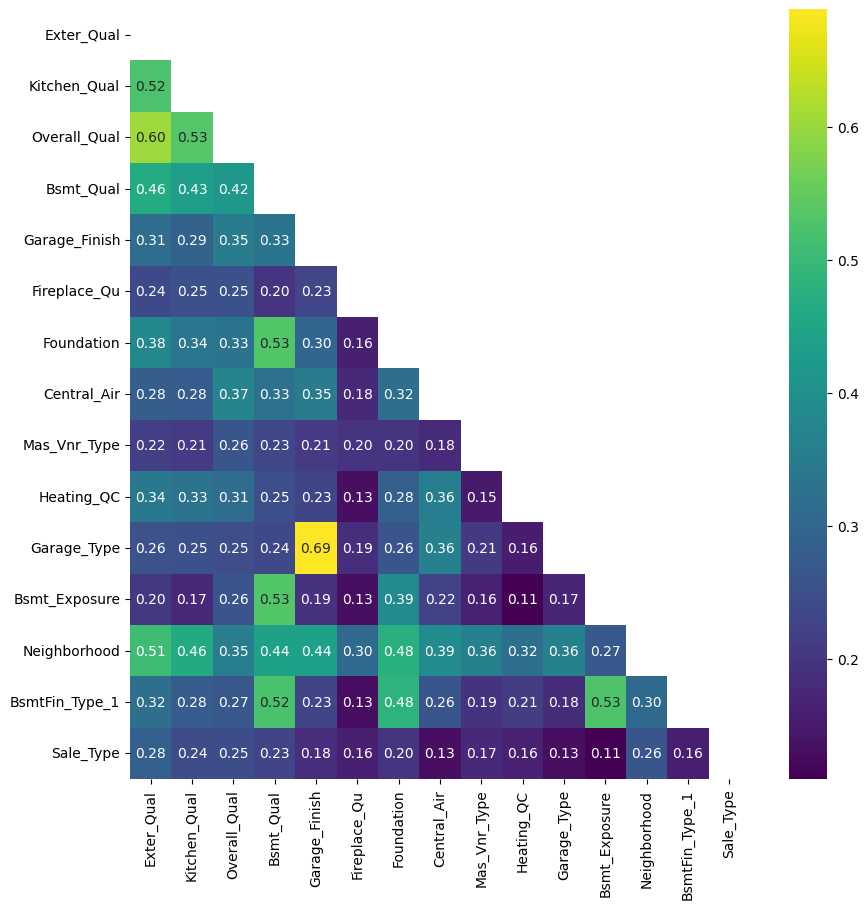

In [170]:
# lets focus on top 15 categorical variables (predictors - Xi)

plt.figure(figsize=(10, 10))
sns.heatmap(
    houses_cramers_v_matrix.iloc[:15, :15],
    annot = True,
    cmap = 'viridis',
    fmt = '.2f',
    mask = mask[:15, :15]
)

# there are no very strong relationships:
# Garage_Type vs Garage_Finish
# Exter_Qual vs Overall_Qual

In [174]:
# create a list of SELECTED categorical predictors:
# 15 with the highest Cramer's V with the Sale_Price

houses_selected_categorical_vars = houses_anova_results[0:15]['Variable'].tolist()

print(houses_selected_categorical_vars)

['Exter_Qual', 'Kitchen_Qual', 'Overall_Qual', 'Bsmt_Qual', 'Garage_Finish', 'Fireplace_Qu', 'Foundation', 'Central_Air', 'Mas_Vnr_Type', 'Heating_QC', 'Garage_Type', 'Bsmt_Exposure', 'Neighborhood', 'BsmtFin_Type_1', 'Sale_Type']


In [176]:
# but exclude from this list 2 Xi which are strongly mutually related with other Xi:
# Garage_Type and Overall_Qual

houses_selected_categorical_vars.remove('Garage_Type')
houses_selected_categorical_vars.remove('Overall_Qual')

print(houses_selected_categorical_vars)

['Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual', 'Garage_Finish', 'Fireplace_Qu', 'Foundation', 'Central_Air', 'Mas_Vnr_Type', 'Heating_QC', 'Bsmt_Exposure', 'Neighborhood', 'BsmtFin_Type_1', 'Sale_Type']


In [178]:
# In the end we can combine them into a single list of SELECATED predictors
# - 12 numerical most correlated with the target
# - 13 categorical most related (ANOVA) with the target

houses_selected_vars = houses_selected_numeric_vars + houses_selected_categorical_vars

houses_selected_vars

['Gr_Liv_Area',
 'Garage_Area',
 'Total_Bsmt_SF',
 'Full_Bath',
 'Year_Built',
 'Year_Remod_Add',
 'Fireplaces',
 'Wood_Deck_SF',
 'Half_Bath',
 'Open_Porch_SF',
 'Bsmt_Full_Bath',
 'Lot_Area',
 'Exter_Qual',
 'Kitchen_Qual',
 'Bsmt_Qual',
 'Garage_Finish',
 'Fireplace_Qu',
 'Foundation',
 'Central_Air',
 'Mas_Vnr_Type',
 'Heating_QC',
 'Bsmt_Exposure',
 'Neighborhood',
 'BsmtFin_Type_1',
 'Sale_Type']

In [180]:
# save SELECTED variables (Xi) into a pickle file for further analysis

with open('data/houses_selected_vars.pkl', 'wb') as f:
    pickle.dump(houses_selected_vars, f)